In [1]:
import numpy as np

import torch
import quairkit as qkit
from quairkit import to_state, Hamiltonian
from quairkit.database import *
from quairkit.qinfo import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qsp import *
from qite import *

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 18

In [4]:
qkit.set_dtype('complex128')
revise_tol(1e-40)

## Experiment setting

prepare Hamiltonian

In [5]:
num_qubits = 4

H = normalized_heisenberg_hamiltonian(n=num_qubits, factor=1.5, hx=-0.5, hz=0, hxx=-1, hyy=-1, hzz=-1)

In [6]:
eigvals, eigvecs = torch.linalg.eigh(H.matrix)

ground_state_energy = eigvals[0].item()
ground_state = to_state(eigvecs[:, 0])

print(f'ground state energy = {ground_state_energy}')

ground state energy = -0.5156684612641718


Prepare input state as the four-qubit zero state

In [7]:
phi_state = zero_state(num_qubits)

gamma = torch.abs(phi_state.bra @ ground_state.ket).item()
print(f'The state overlap between input state and ground state is {gamma}')

The state overlap between input state and ground state is 0.2499999999999997


Prepare evolution operator

In [8]:
U = torch.matrix_exp(-1j * H.matrix)

## Compute data

In [9]:
list_tau = list(np.arange(50, 9, -2.5))

list_probability, list_E_tau = [], []

In [10]:
proj = nkron(zero_state(1).bra, eye(2 ** (num_qubits)))
input_state = nkron(zero_state(1), phi_state)

for tau in list_tau:
    deg = max(50, even_floor(0.056 * (tau**3) -4.47 * (tau**2) + 121.36 * tau - 500))

    guess_lambda = -ground_state_energy + 1 / tau

    list_theta, list_phi = qite.get_qpp_angle(guess_lambda=guess_lambda, tau=tau, deg=deg)
    
    cir = qpp_cir(list_theta, list_phi, U)
    output_state = proj @ cir(input_state).ket
    state_norm = torch.linalg.norm(output_state).item()
    
    list_probability.append(state_norm**2)
    output_state = output_state / state_norm

    output_state = to_state(output_state)
    list_E_tau.append((output_state.bra @ H.matrix @ output_state.ket).real.item())

## Plot

In [11]:
probability_lower_bound = 0.85**2 * np.exp(-2) * np.abs(gamma)**2

In [12]:
probability_lower_bound

0.006111233883653277

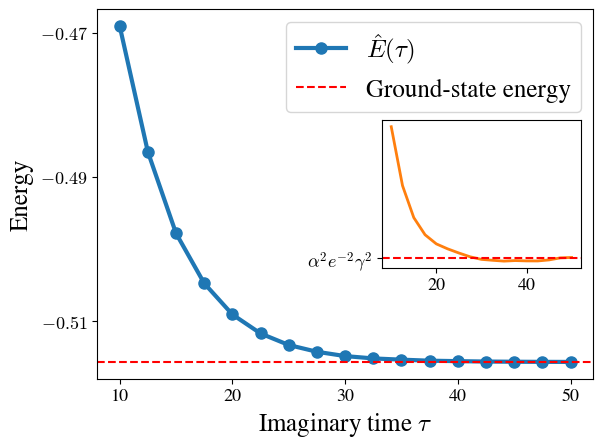

In [13]:
# Font size for labels and titles
fontsize = 18

# Plot the energy vs imaginary time
plt.plot(list_tau, list_E_tau, 'o-', label=r'$\hat{E}(\tau)$', linewidth=3, markersize=8)

# Draw a horizontal line at the minimum eigenvalue (ground state energy)
plt.axhline(y=ground_state_energy, color='r', linestyle='--', label=r'Ground-state energy')

# Set axis labels
plt.xlabel(r'Imaginary time $\tau$', fontsize=fontsize)
plt.ylabel('Energy', fontsize=fontsize)

# Add legend to the main plot
plt.legend(loc='upper right', fontsize=fontsize)

plt.xticks([10, 20, 30, 40, 50])
# Define custom y-ticks for better readability
yticks0 = [-0.47, -0.49, -0.51]
plt.yticks(yticks0, [f'${tick:.2f}$' for tick in yticks0])
plt.tick_params(labelsize=13)  # Increase tick label size

# Fix lower y-limit for consistency
# plt.ylim(-0.524, None)

# Create an inset axes for projection to zero state
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc='center right')

# Plot the projection to the zero state over imaginary time
ax_inset.plot(list_tau, list_probability, '-', color='C1', linewidth=2)

# Draw a horizontal line indicating the theoretical bound
ax_inset.axhline(y=probability_lower_bound, color='r', linestyle='--')

# Set y-ticks for the inset plot
# Ensure that projection_bound is a scalar value
ax_inset.set_yticks([probability_lower_bound])
ax_inset.set_yticklabels([r'$\alpha^2 e^{-2} \gamma^2$'])

# Adjust font size of tick labels in the inset
ax_inset.tick_params(labelsize=13)

# Display the final figure
plt.show()

---

In [14]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.0
torch: 2.7.0+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.10.0
---------SYSTEM---------
Python version: 3.10.16
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
